Instructions on how to use this notebook:

Make sure you have connected your kernel to your conda environment.

You need your data, and annotations and one of our onnx models.

This tutorial uses CUDA Toolkit 12.4. Make sure to replace your torch version with whatever CUDA version you are using:
- https://pytorch.org/get-started/locally/
- https://developer.nvidia.com/cuda-12-4-0-download-archive?target_os=Linux

In [17]:
!pip list

Package                   Version
------------------------- --------------
anyio                     4.9.0
argon2-cffi               25.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.5
attrs                     25.3.0
babel                     2.17.0
beautifulsoup4            4.13.4
bleach                    6.2.0
certifi                   2025.6.15
cffi                      1.17.1
charset-normalizer        3.4.2
coloredlogs               15.0.1
comm                      0.2.2
contourpy                 1.3.2
cycler                    0.12.1
debugpy                   1.8.14
decorator                 5.2.1
defusedxml                0.7.1
exceptiongroup            1.3.0
executing                 2.2.0
fastjsonschema            2.21.1
filelock                  3.13.1
flatbuffers               25.2.10
fonttools                 4.58.4
fqdn                      1.5.1
fsspec                    2024.6.1
h11     

In [1]:
## If using google drive colab
# from google.colab import drive
# drive.mount('/content/drive')

#%cd /content/drive/MyDrive/WangE2E/WangE2E


In [2]:
import torch

!pwd

# import os
# os.environ['CUDA_HOME'] = '/usr/local/cuda-12.4'  # Replace with your CUDA installation path
# os.environ['PATH'] = os.environ['PATH'] + ':/usr/local/cuda-12.4/bin'  # Replace with your CUDA installation path
# import torch
# print(torch.cuda.is_available())


!python --version
!nvcc -V
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(torch.cuda.current_device()))

/home/a1245342local/WangE2E
Python 3.10.18
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Feb_27_16:19:38_PST_2024
Cuda compilation tools, release 12.4, V12.4.99
Build cuda_12.4.r12.4/compiler.33961263_0
True
2
0


In [3]:
# You can comment these install cells after running them once for your environment.
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124


In [4]:
!pip3 install numpy matplotlib opencv-python

In [5]:
import cv2
import os
import numpy as np
import json

# Define the output directory and image size
output_dir = 'images/resized/train'
image_size = (640, 640)

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the annotations
with open('annotations/instances.json', 'r') as f:
    instances_annotations = json.load(f)

# Update the annotations and resize the images
for image in instances_annotations['images']:
    image_file = image['file_name']
    image_path = os.path.join('images/train', image_file)
    image_resized_path = os.path.join(output_dir, image_file)

    # Load the image and resize it
    image_data = cv2.imread(image_path)
    image_resized = cv2.resize(image_data, image_size)

    # Save the resized image
    cv2.imwrite(image_resized_path, image_resized)

    # Update the annotations
    for annotation in instances_annotations['annotations']:
        if annotation['image_id'] == image['id']:
            x, y, w, h = annotation['bbox']
            scale_x = image_size[0] / image_data.shape[1]
            scale_y = image_size[1] / image_data.shape[0]
            x_resized = int(x * scale_x)
            y_resized = int(y * scale_y)
            w_resized = int(w * scale_x)
            h_resized = int(h * scale_y)

            # Update the annotation
            annotation['bbox'] = [x_resized, y_resized, w_resized, h_resized]

# Save the updated annotations
with open('annotations/instances_resized.json', 'w') as f:
    json.dump(instances_annotations, f)

Loading image images/resized/train/ti_lindau_V106_2015sept_100_VIRB_VIRB0031_10m_10m_I07710.jpg


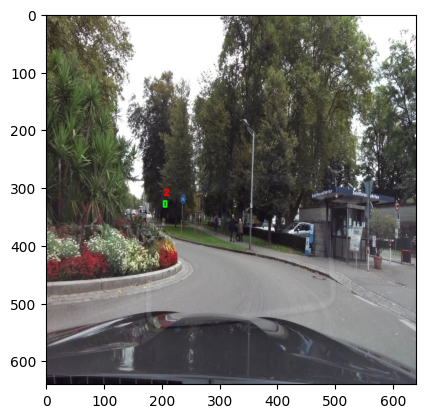

Loading image images/resized/train/ti_lindau_V106_2015sept_100_VIRB_VIRB0031_10m_10m_I07710.jpg


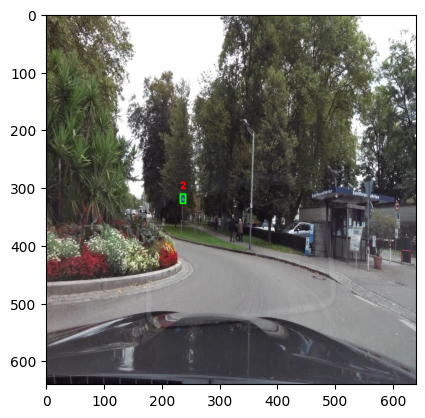

Loading image images/resized/train/ti_lindau_V106_2015sept_100_VIRB_VIRB0031_10m_10m_I07710.jpg


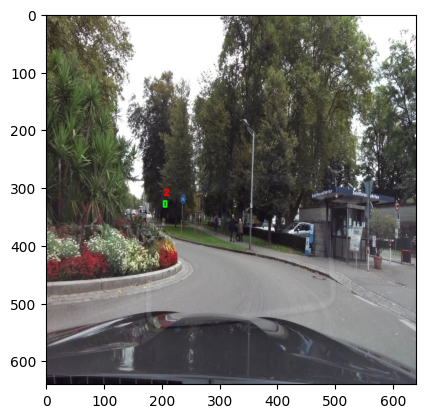

Loading image images/resized/train/ti_lindau_V106_2015sept_100_VIRB_VIRB0031_10m_10m_I07710.jpg


In [6]:
import cv2
import os
import numpy as np
import json
import matplotlib.pyplot as plt

# Load the updated annotations
with open('annotations/instances_resized.json', 'r') as f:
    instances_annotations = json.load(f)

image_dir = 'images/resized/train'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
image_id_to_file = {}
for image in instances_annotations['images']:
    image_id_to_file[image['id']] = image['file_name']
image_paths = []
for image_id in [annotation['image_id'] for annotation in instances_annotations['annotations']]:
    image_file = image_id_to_file[image_id]
    image_path = os.path.join(image_dir, image_file)
    image_paths.append(image_path)

numOutputImages = 3
for i, (image_path, annotation) in enumerate(zip(image_paths, instances_annotations['annotations'])):
    print(f"Loading image {image_path}")
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image {image_path}")
        continue
    x, y, w, h = annotation['bbox']
    x1, y1, x2, y2 = int(x), int(y), int(x + w), int(y + h)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, str(annotation['category_id']), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    if i < numOutputImages:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.show()
    else:
        break

In [7]:
!pip install ultralytics

In [8]:
import os
import json
import shutil
from pathlib import Path

def convert_coco_to_yolo(coco_json_path, images_dir, output_dir):
    output_dir = Path(output_dir)
    (output_dir / 'images' / 'train').mkdir(parents=True, exist_ok=True)
    (output_dir / 'labels' / 'train').mkdir(parents=True, exist_ok=True)
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    image_id_to_info = {img['id']: img for img in coco_data['images']}
    category_id_to_index = {cat['id']: idx for idx, cat in enumerate(coco_data['categories'])}
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)
    for image_id, annotations in annotations_by_image.items():
        image_info = image_id_to_info[image_id]
        image_filename = image_info['file_name']
        image_width = image_info['width']
        image_height = image_info['height']
        src_image_path = os.path.join(images_dir, image_filename)
        dst_image_path = output_dir / 'images' / 'train' / image_filename
        if os.path.exists(src_image_path):
            shutil.copy2(src_image_path, dst_image_path)
        label_filename = os.path.splitext(image_filename)[0] + '.txt'
        label_path = output_dir / 'labels' / 'train' / label_filename
        with open(label_path, 'w') as f:
            for ann in annotations:
                x, y, w, h = ann['bbox']
                center_x = (x + w / 2) / image_width
                center_y = (y + h / 2) / image_height
                norm_width = w / image_width
                norm_height = h / image_height
                class_id = category_id_to_index[ann['category_id']]
                f.write(f"{class_id} {center_x:.6f} {center_y:.6f} {norm_width:.6f} {norm_height:.6f}\n")
    return category_id_to_index

category_mapping = convert_coco_to_yolo('annotations/instances_resized.json', 'images/resized/train', 'yolo_dataset_resized')
print("Conversion completed!")
print(f"Category mapping: {category_mapping}")

Conversion completed!
Category mapping: {1: 0, 2: 1, 3: 2}


In [9]:
import json
import yaml

# Create class names list
with open('annotations/instances_resized.json', 'r') as f:
    coco_data = json.load(f)
class_names = [cat['name'] for cat in sorted(coco_data['categories'], key=lambda x: x['id'])]
dataset_config = {
    'path': './yolo_dataset_resized',  # dataset root dir
    'train': 'images/train',   # train images (relative to 'path')
    'val': 'images/train',     # val images (relative to 'path') - using same as train for simplicity
    'nc': len(class_names),    # number of classes
    'names': class_names       # class names
}
with open('dataset_resized.yaml', 'w') as f:
    yaml.dump(dataset_config, f, default_flow_style=False)
print("Dataset configuration created!")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

Dataset configuration created!
Number of classes: 3
Class names: ['human', 'trafficsign', 'vehicle']


In [10]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [11]:
from ultralytics import YOLO

yolo_ckpt = 'yolov8m'

model = YOLO(yolo_ckpt + '.pt')  # or yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt


results = model.train(
    data='dataset_resized.yaml',      # path to dataset YAML
    epochs=10,               # number of training epochs
    imgsz=640,               # training image size
    batch=8,                # batch size
    name='custom_'+ yolo_ckpt +'_resized',    # experiment name
    save=True,               # save checkpoints
    plots=True,              # save plots
    device='cuda'             # use 'cuda' if you have GPU
)

print("Training completed!")


Ultralytics 8.3.161 🚀 Python-3.10.18 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_resized.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=custom_yolov8m_resized3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

train: Scanning /home/a1245342local/WangE2E/yolo_dataset_resized/labels/train.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]

train: /home/a1245342local/WangE2E/yolo_dataset_resized/images/train/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00000.jpg: 4 duplicate labels removed
train: /home/a1245342local/WangE2E/yolo_dataset_resized/images/train/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00001.jpg: 1 duplicate labels removed
train: /home/a1245342local/WangE2E/yolo_dataset_resized/images/train/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00055.jpg: 1 duplicate labels removed
train: /home/a1245342local/WangE2E/yolo_dataset_resized/images/train/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00085.jpg: 2 duplicate labels removed
train: /home/a1245342local/WangE2E/yolo_dataset_resized/images/train/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00145.jpg: 2 duplicate labels removed
train: /home/a1245342local/WangE2E/yolo_dataset_resized/images/train/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00175.jpg: 1 duplicate labels removed
train: /home/a1245342local/WangE2E/yolo_dataset_resized/im

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1660.6±737.4 MB/s, size: 142.6 KB)


val: Scanning /home/a1245342local/WangE2E/yolo_dataset_resized/labels/train.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]

train: /home/a1245342local/WangE2E/yolo_dataset_resized/images/train/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00000.jpg: 4 duplicate labels removed
train: /home/a1245342local/WangE2E/yolo_dataset_resized/images/train/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00001.jpg: 1 duplicate labels removed
train: /home/a1245342local/WangE2E/yolo_dataset_resized/images/train/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00055.jpg: 1 duplicate labels removed
train: /home/a1245342local/WangE2E/yolo_dataset_resized/images/train/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00085.jpg: 2 duplicate labels removed
train: /home/a1245342local/WangE2E/yolo_dataset_resized/images/train/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00145.jpg: 2 duplicate labels removed
train: /home/a1245342local/WangE2E/yolo_dataset_resized/images/train/ti_lindau_V105_2015sept_100_VIRB_VIRB0031_0m_10m_I00175.jpg: 1 duplicate labels removed
train: /home/a1245342local/WangE2E/yolo_dataset_resized/im

Plotting labels to runs/detect/custom_yolov8m_resized3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/custom_yolov8m_resized3
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.92G      4.276      7.766      2.661         26        640: 100%|██████████| 63/63 [00:21<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]

                   all        500       9366    0.00141     0.0173   0.000805   0.000226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.66G      4.215      3.981      2.201         20        640: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]

                   all        500       9366    0.00095    0.00852   0.000503   0.000124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.72G      4.155      3.912      2.094         39        640: 100%|██████████| 63/63 [00:21<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]

                   all        500       9366   0.000253   0.000296   0.000127   3.82e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.79G       4.13      3.814      2.057         48        640: 100%|██████████| 63/63 [00:21<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.23it/s]

                   all        500       9366      0.669    0.00815   0.000774   0.000174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.79G      4.089      3.703      2.091         29        640: 100%|██████████| 63/63 [00:22<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]

                   all        500       9366      0.338     0.0111    0.00163   0.000378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.79G      4.044      3.707      2.052         54        640: 100%|██████████| 63/63 [00:22<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]

                   all        500       9366    0.00189     0.0629    0.00157   0.000374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10       4.8G      4.014      3.575      1.954         40        640: 100%|██████████| 63/63 [00:22<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]

                   all        500       9366    0.00245     0.0665    0.00255    0.00067



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.86G      3.976      3.528      1.964         80        640: 100%|██████████| 63/63 [00:22<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]

                   all        500       9366    0.00292     0.0695    0.00216   0.000564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.93G      3.907      3.508      1.993         52        640: 100%|██████████| 63/63 [00:22<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]

                   all        500       9366    0.00313     0.0762    0.00306    0.00074



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         5G      3.903      3.459      1.938         35        640: 100%|██████████| 63/63 [00:22<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]

                   all        500       9366    0.00294     0.0763    0.00266   0.000704



10 epochs completed in 0.083 hours.
Optimizer stripped from runs/detect/custom_yolov8m_resized3/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/custom_yolov8m_resized3/weights/best.pt, 52.0MB

Validating runs/detect/custom_yolov8m_resized3/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.10.18 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
Model summary (fused): 92 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


                   all        500       9366    0.00314     0.0763    0.00307   0.000741
                 human        463       3024    0.00236    0.00529    0.00168   0.000279
           trafficsign        357       1841          0          0          0          0
               vehicle        493       4501    0.00704      0.224    0.00753    0.00194
Speed: 0.2ms preprocess, 12.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/custom_yolov8m_resized3
Training completed!



Processing image 1: images/resized/train/ti_lindau_V106_2015sept_100_VIRB_VIRB0031_10m_10m_I07710.jpg

image 1/1 /home/a1245342local/WangE2E/images/resized/train/ti_lindau_V106_2015sept_100_VIRB_VIRB0031_10m_10m_I07710.jpg: 640x640 (no detections), 120.3ms
Speed: 0.7ms preprocess, 120.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
No objects detected


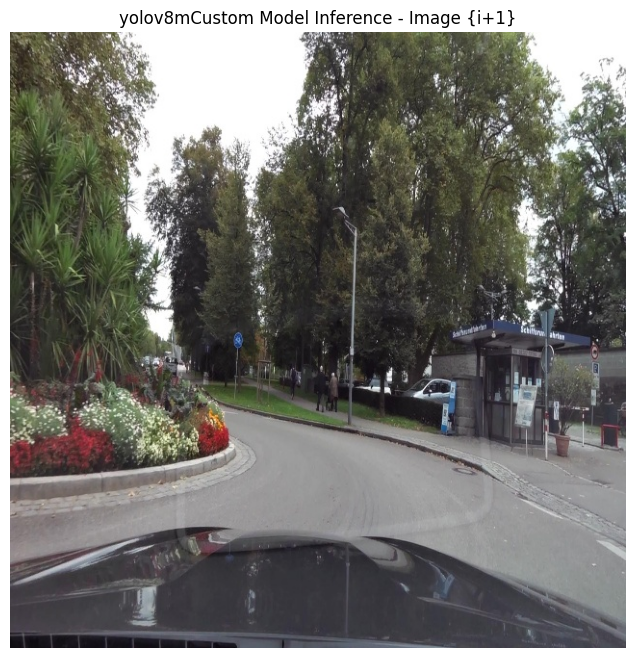


Processing image 2: images/resized/train/ti_lindau_V106_2015sept_100_VIRB_VIRB0031_10m_10m_I07710.jpg

image 1/1 /home/a1245342local/WangE2E/images/resized/train/ti_lindau_V106_2015sept_100_VIRB_VIRB0031_10m_10m_I07710.jpg: 640x640 (no detections), 132.1ms
Speed: 1.2ms preprocess, 132.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
No objects detected


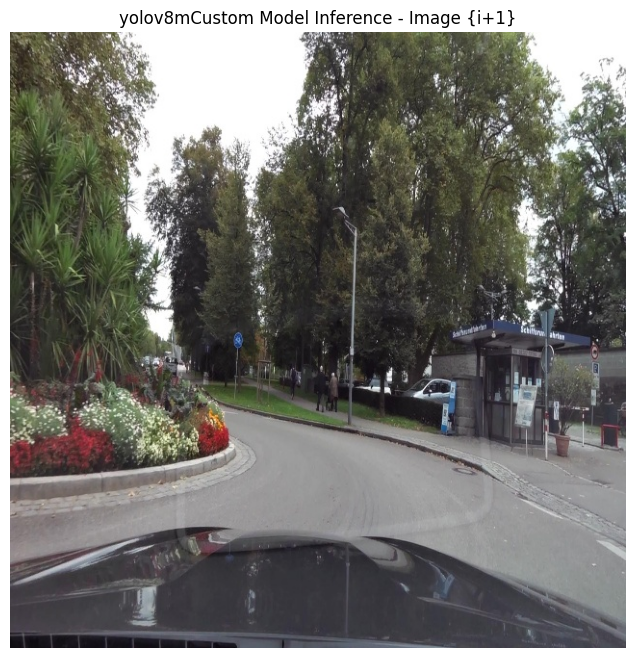


Processing image 3: images/resized/train/ti_lindau_V106_2015sept_100_VIRB_VIRB0031_10m_10m_I07710.jpg

image 1/1 /home/a1245342local/WangE2E/images/resized/train/ti_lindau_V106_2015sept_100_VIRB_VIRB0031_10m_10m_I07710.jpg: 640x640 (no detections), 130.7ms
Speed: 0.9ms preprocess, 130.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
No objects detected


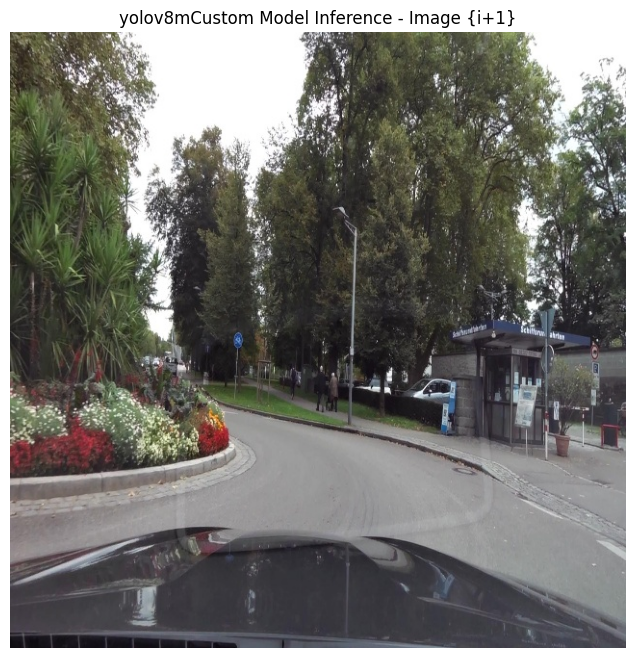


Model Summary:
Classes: ['human', 'trafficsign', 'vehicle']
Number of classes: 3


In [14]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

model = YOLO('runs/detect/custom_'+ yolo_ckpt +'_resized/weights/best.pt')
model.to('cuda')  # Force model to use CPU

test_images = image_paths[:3]  # Use first 5 images from your dataset

for i, image_path in enumerate(test_images):
    print(f"\nProcessing image {i+1}: {image_path}")

    results = model(image_path, conf=0.25, iou=0.45, device='cpu')

    result = results[0]

    if len(result.boxes) > 0:
        print(f"Detected {len(result.boxes)} objects:")
        for box in result.boxes:
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = model.names[class_id]
            print(f"  - {class_name}: {confidence:.3f}")
    else:
        print("No objects detected")

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if len(result.boxes) > 0:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = model.names[class_id]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            label = f"{class_name}: {confidence:.2f}"
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(f""+yolo_ckpt+"Custom Model Inference - Image {i+1}")
    plt.axis('off')
    plt.show()

print(f"\nModel Summary:")
print(f"Classes: {list(model.names.values())}")
print(f"Number of classes: {len(model.names)}")


In [15]:
!pip3 install onnx
from ultralytics import YOLO

# Change the run path to your run.
model = YOLO('runs/detect/custom_'+yolo_ckpt+'_resized/weights/best.pt')

model.export(
    format='onnx',          # Export format
    imgsz=640,             # Image size (should match training size)
    dynamic=True,          # Allow dynamic input sizes
    simplify=True,         # Simplify the model graph
    opset=18,              # ONNX opset version
    half=False             # Use FP32 precision (set True for FP16)
)

print("Model exported to ONNX format successfully!")
print("Exported file: runs/detect/custom_"+yolo_ckpt+"resized/weights/best.onnx")


Ultralytics 8.3.161 🚀 Python-3.10.18 torch-2.6.0+cu124 CPU (12th Gen Intel Core(TM) i7-12700K)
Model summary (fused): 92 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs

PyTorch: starting from 'runs/detect/custom_yolov8m_resized/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (49.6 MB)

ONNX: starting export with onnx 1.17.0 opset 18...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success ✅ 3.4s, saved as 'runs/detect/custom_yolov8m_resized/weights/best.onnx' (98.7 MB)

Export complete (3.8s)
Results saved to /home/a1245342local/WangE2E/runs/detect/custom_yolov8m_resized/weights
Predict:         yolo predict task=detect model=runs/detect/custom_yolov8m_resized/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/custom_yolov8m_resized/weights/best.onnx imgsz=640 data=dataset_resized.yaml  
Visualize:       https://netron.app
Model exported to ONNX format successfully!
Exported file: runs/detect/cus

In [16]:
# simplify and set shapes
import os
import onnx
import onnx.shape_inference
import onnx.version_converter
from onnxsim import simplify
# import onnxruntime as ort
from onnxruntime.tools import make_dynamic_shape_fixed



model_name = 'custom_'+yolo_ckpt+'_resized'
models_path = '/home/a1245342local/WangE2E/runs/detect/'+model_name+'/weights'

original_model = 'best.onnx'
output_modelname = model_name + '_fixed.onnx'
input_name = 'images'
input_shape = [1,3,640,640]
OPSET_VER = 18
CLEAR_SHAPES = True
CHANGE_INPUT_DIMS = True
SIMPLIFY = True

model = onnx.load(os.path.join(models_path, original_model))

if CLEAR_SHAPES:
    while len(model.graph.value_info) > 0:
        model.graph.value_info.pop()

if CHANGE_INPUT_DIMS:
    for inp in model.graph.input:
        for i, d in enumerate(inp.type.tensor_type.shape.dim):
            inp.type.tensor_type.shape.dim[i].ClearField('dim_value')
    for out in model.graph.output:
        for i, d in enumerate(out.type.tensor_type.shape.dim):
            out.type.tensor_type.shape.dim[i].ClearField('dim_value')
    make_dynamic_shape_fixed.make_input_shape_fixed(model.graph, input_name, input_shape)

model = onnx.shape_inference.infer_shapes(model)

if SIMPLIFY:
    model, check = simplify(model, skip_shape_inference=True)
    print(check)

model = onnx.shape_inference.infer_shapes(model)
onnx.save(model, os.path.join(models_path, output_modelname))

# you can find your fixed model in the weights dir.

True


YOU CAN NOW SAVE THE FIXED.ONNX FILE AND COMPILE WITH EDGE AI TIDL TOOLS.